# Final Report Code for ML_Masters Team
Philip Osborne, Pithayuth Charnsethikul, & Raveena Kshatriya 


**Youtube video:** https://www.youtube.com/watch?v=fXrftNH-ZSU

**Environment Setup**

Before running the notebook, create a virtual environment using **Python 3.9 (Tested only on Python 3.9.2)** in the project directory and activate it. Install the requirements using
    
    pip install -r requirements.txt
    
Then restart/reopen the jupyter notebook. Make sure to also change the path to the Kaggle data to your local directory in cells 3 and 4.

If there are any issues with this, you can run the matching colab notebook instead which should have all the proper packages installed: https://colab.research.google.com/drive/1k_AwIQdbIx0gnPkhZLEXHJ7hrcJXruvu#scrollTo=edzffZ9VrHJP

In [1]:
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
import pickle
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import chi2, f_regression, RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
import time
from mlxtend.regressor import StackingCVRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#sys.path.append('/content/gdrive/MyDrive/')
gdrive_base = './csci567-project/data/' # Change to your local path to the data

In [30]:
#Load Raw Data
train = pd.read_csv(gdrive_base + 'train.csv')
test = pd.read_csv(gdrive_base + 'test.csv')

## Previous Data Analysis<br>
3 key points to take away from the previous analysis of checkpoint 1

1. **Outliers**:<br>
We determine the outliers by <br>
1) choose the features that highly correlate with the target<br>
2) plot the graph between the feature and target<br>
3) identify the potential outliers<br>

Remove samples whose **GrLivArea** is greater than 4,500

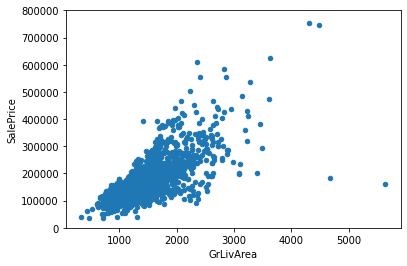

In [ ]:
train.plot.scatter(x ='GrLivArea', y= 'SalePrice', ylim = (0,800000));

Remove samples whose **LotArea** is greater than 100,000

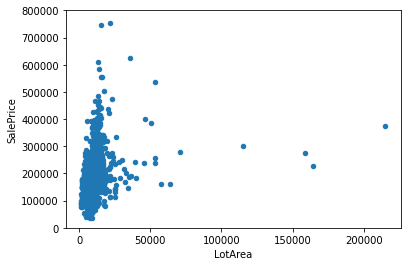

In [ ]:
train.plot.scatter(x ='LotArea', y= 'SalePrice', ylim = (0,800000));

Remove samples whose **LotFrontage** is greater than 200

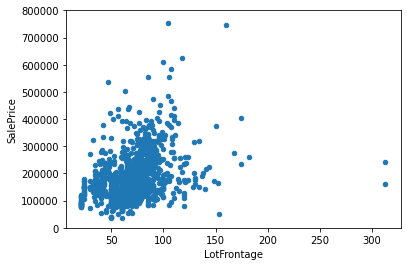

In [ ]:
train.plot.scatter(x ='LotFrontage', y= 'SalePrice', ylim = (0,800000));

2. **Missing Data**<br>
We remove the features that have the percentage of missing data greater than 50%

In [ ]:
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([percent], axis = 1, keys = ['Percent'])
missing_data.head(5)

,Percent
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603


3. **Collinear Feature**<br>
Both GarageArea and GarageCars highly correlate with the target (SalePrice). They also correlate with each other. Thus, we can drop one of them (we choose GarageCars and drop GarageArea)

In [ ]:
print('Correlation between GarageCars & SalePrice: {}'.format(train['GarageCars'].corr(train['SalePrice'])))
print('Correlation between GarageArea & SalePrice: {}'.format(train['GarageArea'].corr(train['SalePrice'])))
print('Correlation between GarageCars & GarageArea: {}'.format(train['GarageArea'].corr(train['GarageCars'])))

Correlation between GarageCars & SalePrice: 0.6404091972583529
Correlation between GarageArea & SalePrice: 0.6234314389183618
Correlation between GarageCars & GarageArea: 0.8824754142814625


## Data Preprocessing

In [5]:
#Fill missing values, and fix values that shouldn't be interpreted as missing
def fill_missing(dataset) :

  #Convert some numerical features to objects
  dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
  dataset['YrSold'] = dataset['YrSold'].astype(object)
  dataset['MoSold'] = dataset['MoSold'].astype(object)

  #Fill the values that shouldn't be interpreted as NA
  dataset['Alley'] = dataset['Alley'].fillna('None')
  dataset['MiscFeature'] = dataset['MiscFeature'].fillna('None')
  dataset['Fence'] = dataset['Fence'].fillna('None')
  dataset['MasVnrType'] = dataset['MasVnrType'].fillna('None')
  dataset['GarageType'] = dataset['GarageType'].fillna('None')
  dataset['LotFrontage'] = dataset['LotFrontage'].fillna(0)
  dataset['MasVnrArea'] = dataset['MasVnrArea'].fillna(0)
  dataset['Electrical'] = dataset['Electrical'].fillna('Unknown') 
  dataset['GarageYrBlt'] = dataset['GarageYrBlt'].fillna(int(train['GarageYrBlt'].mean()))

  # Testset missing data
  dataset['MSZoning'] = dataset['MSZoning'].fillna('None')
  dataset['Exterior1st'] = dataset['Exterior1st'].fillna('None')
  dataset['Exterior2nd'] = dataset['Exterior2nd'].fillna('None')
  dataset['SaleType'] = dataset['SaleType'].fillna('None')
  dataset['BsmtFullBath'] = dataset['BsmtFullBath'].fillna(0)
  dataset['BsmtHalfBath'] = dataset['BsmtHalfBath'].fillna(0)
  dataset['BsmtFinSF2'] = dataset['BsmtFinSF2'].fillna(0)
  dataset['TotalBsmtSF'] = dataset['TotalBsmtSF'].fillna(0)
  dataset['GarageArea'] = dataset['GarageArea'].fillna(0)
  dataset['GarageCars'] = dataset['GarageCars'].fillna(0)
  dataset['BsmtUnfSF'] = dataset['BsmtUnfSF'].fillna(0)
  dataset['BsmtFinSF1'] = dataset['BsmtFinSF1'].fillna(0)

  return dataset

In [6]:
#Map ordinal features from strings to numbers
def str_to_ord(dataset) :

  lot_shape_mapping = {"IR3": 4, "IR2": 3, "IR1": 2, "Reg":1}
  utilities_mapping = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub":4}
  land_slope_mapping = {"Sev": 3, "Mod": 2, "Gtl": 1}
  exter_mapping = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
  bsmt_mapping = {"NA": 1, "Po": 2, "Fa": 3, "TA": 4, "Gd": 5, "Ex": 6}
  bsmt_exposure_mapping = {"NA": 1, "No": 2, "Mn": 3, "Av":4, "Gd": 5}
  bsmt_fin_mapping = {"NA": 1, "Unf": 2, "LwQ": 3, "Rec":4, "BlQ": 5, "AlQ": 6, "GlQ": 7}
  functional_mapping = {"Sal": 1, "Sev": 2, "Maj2": 3, "Maj1":4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}
  garage_finish_mapping = {"NA": 1, "Unf": 2, "RFn": 3, "Fin":4}
  pool_mapping = {'NA': 1, 'FA': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
  paved_mapping = {'N':0, 'P': 1, 'Y': 2}
  dataset['LotShape'] = dataset['LotShape'].map(lot_shape_mapping).astype(int)
  #dataset['Utilities'] = dataset['Utilities'].map(utilities_mapping).astype(int)
  dataset['LandSlope'] = dataset['LandSlope'].map(land_slope_mapping).astype(int)
  dataset["ExterQual"] = dataset["ExterQual"].map(exter_mapping).astype(int)
  dataset["ExterCond"] = dataset["ExterCond"].map(exter_mapping).astype(int)
  dataset["BsmtQual"] = dataset["BsmtQual"].map(bsmt_mapping).fillna(1).astype(int)
  dataset["BsmtCond"] = dataset["BsmtCond"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['BsmtExposure'] = dataset['BsmtExposure'].map(bsmt_exposure_mapping).fillna(1).astype(int)
  dataset['BsmtFinType1'] = dataset['BsmtFinType1'].map(bsmt_fin_mapping).fillna(1).astype(int)
  dataset['BsmtFinType2'] = dataset['BsmtFinType2'].map(bsmt_fin_mapping).fillna(1).astype(int)
  dataset["HeatingQC"] = dataset["HeatingQC"].map(exter_mapping).fillna(1).astype(int)
  dataset["KitchenQual"] = dataset["KitchenQual"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['Functional'] = dataset['Functional'].map(functional_mapping).fillna(8).astype(int)
  dataset["FireplaceQu"] = dataset["FireplaceQu"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['GarageFinish'] = dataset['GarageFinish'].map(garage_finish_mapping).fillna(1).astype(int)
  dataset["GarageQual"] = dataset["GarageQual"].map(bsmt_mapping).fillna(1).astype(int)
  dataset["GarageCond"] = dataset["GarageCond"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['PoolQC'] = dataset['PoolQC'].map(pool_mapping).fillna(1).astype(int)
  dataset['PavedDrive'] = dataset['PavedDrive'].map(paved_mapping).astype(int)
  return dataset

In [7]:
# Engineer new features by combining related features, other feature manipulations
def feat_eng(dataset) :
  dataset['TotalSF'] = dataset[['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2', 'TotalBsmtSF', 'GarageArea']].sum(axis=1)
  dataset['TotalBath'] = dataset['BsmtFullBath']+dataset['FullBath']+0.5*(dataset['HalfBath']+dataset['BsmtHalfBath'])
  dataset['TotalPorchSF'] = dataset[['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']].sum(axis=1)

  #Combine related features
  dataset['ExterQualCond'] = dataset['ExterQual']+dataset['ExterCond']
  dataset['GrgQualCond'] = dataset['GarageQual']+dataset['GarageCond']
  dataset['BsmtQualCond'] = dataset['BsmtQual']+dataset['BsmtCond']+dataset['BsmtFinType1']+dataset['BsmtFinType2']
  dataset['OverallQualCond'] = dataset['OverallQual']+dataset['OverallCond']
  dataset['TotalQual'] = dataset['ExterQualCond']+dataset['GrgQualCond']+dataset['BsmtQualCond']+dataset['OverallQual']+dataset['HeatingQC']+dataset['KitchenQual']

  #add some indicator features
  dataset['HasGarage'] = dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasBsmt'] = dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasPool'] = dataset['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasFireplace'] = dataset['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasPorch'] = dataset['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0)

  #drop irrelevant features
  dataset.drop(columns=['ExterQual','BsmtQual','GarageQual','HeatingQC','Utilities'],inplace=True)
  #drop features whose percentage of missing data are greater than 0.5
  dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'],inplace=True)
  #drop collinear features (GarageArea: colliear with GarageCars)
  dataset.drop(columns=['GarageArea'],inplace=True)
  
  return dataset

In [28]:
#Main data preprocessing function applying all of the above
def preprocess_data(dataset,train=True) :

  targets = None
  if train:
    # Deleting outliers: GrLivArea >= 4500
    dataset = dataset[dataset.GrLivArea < 4500]

    # Deleting outliers: LotArea >= 100000
    dataset = dataset[dataset.LotArea < 100000]

    # Deleting outliers: LotFrontage >= 200 (Fill missing data before deleting)
    dataset['LotFrontage'] = dataset['LotFrontage'].fillna(0)
    dataset = dataset[dataset.LotFrontage < 200]

    dataset.reset_index(drop=True, inplace=True)
    
    #Take log of targets, since in Kaggle scoring RMSE is calculated using log of targets
    targets = np.log(dataset['SalePrice'])
    dataset.drop(columns='SalePrice',inplace=True)

  ids = dataset['Id']
  dataset.drop(columns='Id', inplace=True)

  #Handle missing data
  proc_df = fill_missing(dataset)

  #map to ordinal
  proc_df = str_to_ord(proc_df)

  #feature engineering
  proc_df = feat_eng(proc_df)

  #scale numerical features
  num_feat = proc_df.select_dtypes([np.number])
  if train :
    ss = StandardScaler()
    ss.fit(num_feat)
    with open(gdrive_base+'std_scaler.pkl','wb') as f :
      pickle.dump(ss,f)
  else :
    with open(gdrive_base+'std_scaler.pkl','rb') as f :
      ss = pickle.load(f)
  num_feat = ss.transform(num_feat)

  num_feat = pd.DataFrame(num_feat, columns=proc_df.select_dtypes([np.number]).columns)
  #one hot encode categorical features
  cat_feat = proc_df.select_dtypes(['O'])
  if train :
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(cat_feat)
    with open(gdrive_base+'one_hot_enc.pkl','wb') as f :
      pickle.dump(ohe,f)
  else :
    with open(gdrive_base + 'one_hot_enc.pkl','rb') as f :
      ohe = pickle.load(f)
  train_oh = ohe.transform(cat_feat)
  feat_names = ohe.get_feature_names(cat_feat.columns)
  cat_feat = pd.DataFrame(train_oh,columns=feat_names)
  proc_df = pd.concat([num_feat,cat_feat],axis=1)

  if train: 
    print(f"Processed Train Set Shape: {proc_df.shape}")
  else :
    print(f"Processed Test Set Shape: {proc_df.shape}")
  return ids,proc_df,targets

In [31]:
_,train_clean,y_train = preprocess_data(train)
test_ids,test_clean,_ = preprocess_data(test,train=False)

Processed Train Set Shape: (1453, 250)
Processed Test Set Shape: (1459, 250)


# Feature Selection
---

In [ ]:
X_train = train_clean
X_test = test_clean

In [ ]:
#Function that we use to perform K-fold cross validation for our models
def score_model(estimator,X,y,k=5) :
  return cross_validate(estimator,X,y,cv=k,return_train_score=True,scoring='neg_root_mean_squared_error')

In [ ]:
def rfe_feat_select(X_train,y_train,estimator,num_feat) :

  rfe = RFE(estimator,num_feat,step=5)
  rfe.fit(X_train,y_train)
  feat_index = rfe.get_support()
  excerpt = X_train.loc[:,feat_index]
  print(f"{len(excerpt.columns)} features selected")
  return excerpt,rfe

In [ ]:
 #baseline model wihtout any feature selection
lr = LinearRegression()
scores = score_model(lr,X_train,y_train)
avg_train = np.mean(scores['train_score'])
avg_test = np.mean(scores['test_score'])
print(f'Baseline LR Model train score: {avg_train}, test score: {avg_test}')

Baseline LR Model train score: -0.09004572284751958, test score: -249188206.5585869


In [ ]:
feature_sizes = [5,10,20,50,100,150,200,250]
best_index = None
best_test_score = -10000000000000
best_rfe = None
best_lr = None
for n in feature_sizes :
  excerpt,rfe = rfe_feat_select(X_train,y_train,lr,n)
  lr_select = LinearRegression()
  scores = score_model(lr_select,excerpt,y_train)
  test_score = np.mean(scores['test_score'])
  if  test_score > best_test_score :
    best_feat_train_score = np.mean(scores['train_score'])
    best_test_score = test_score
    best_rfe = rfe
    best_index = excerpt.columns
    best_lr = rfe
print(f'RFE best number of features: {len(best_index)}')
print(f'RFE Selected LR Model best val score: {best_test_score}, corresponding train score: {best_feat_train_score}')
print(f'RFE best features: {best_index}')

5 features selected
10 features selected
20 features selected
50 features selected
100 features selected
150 features selected
200 features selected
250 features selected
RFE best number of features: 5
RFE Selected LR Model best val score: -0.21913904793748556, corresponding train score: -0.21825308190253007
RFE best features: Index(['OverallQual', 'OverallCond', 'OverallQualCond', 'Foundation_CBlock',
       'Foundation_PConc'],
      dtype='object')


We experimented with the above feature selection method, but found that the features selected did not perform well during training. For many of the models we experimented with, the best RMSE was achieved using all of the given and engineered features.

# Training


---
### **Overview**

We experiment with several different regression techniques, including Linear Regression, Ridge Regression, Lasso Regression, ElasticNet Regression, Kernel Ridge Regression, Support Vector Regression (SVR), Bayesian Ridge Regression, Linear Support Vector Regression (Linear SVR), Decision Trees, XGBoost, and a Multi-layer Perceptron. We started with simple linear regression as our initial baseline.




In [5]:
#Perform K-Fold Cross Validaton and return average RMSE score across runs
def rmsle_cv(model,X,y,n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return np.mean(rmse)

In [6]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,n_folds,param_grid):
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
        grid_search = GridSearchCV(self.model,param_grid,cv=kf, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [7]:
#Generate Kaggle test set csv for a model
def generate_kaggle_submission(estimator,X_test,model_name) :
  pred = estimator.predict(X_test)
  pred = np.exp(pred)
  filename = f"{gdrive_base}{model_name}_predictions.csv"
  pd.DataFrame(zip(test_ids,pred),columns=['Id','SalePrice']).to_csv(filename,index=False)

## Linear Regression

We experiment with Linear Regression as our baseline model

Top 12 features from feature correlations

In [ ]:
# feature score >= 0.50
top_12 = ['GrLivArea','TotalSF','TotalQual','GarageCars','TotalBath','KitchenQual', 'TotalBsmtSF','OverallQualCond','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd']
X_train = train_clean[top_12]
X_test = test_clean[top_12]

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [ ]:
#5-Fold Cross Validation Score
rmse = rmsle_cv(lr,X_train,y_train)

print(f'Average 5-Fold CV Score: {rmse}')

Average 5-Fold CV Score: 0.13374958016160482


In [ ]:
generate_kaggle_submission(lr,X_test,'LinearRegressionFeatCorr')

## Ridge

In [32]:
#Grab all features for other methods
X_train = train_clean
X_test = test_clean

After applying log to the target (SalePrice), the distribution becomes normal (previously it is skew).

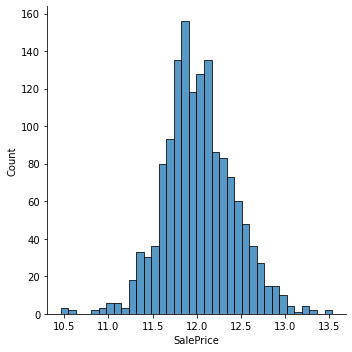

In [33]:
sns.displot(y_train)

We carefully choose the alpha parameter for a ridge model.

In [34]:
train_rmse = []
test_rmse = []
alphas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]

for alp in alphas:
  ridge = Ridge(alpha=alp)
  scores = score_model(ridge, X_train, y_train)
  train_rmse.append(-np.mean(scores['train_score']))
  test_rmse.append(-np.mean(scores['test_score']))

test_rmse = pd.Series(test_rmse, index=alphas)
print('Min (test): alpha={}, rmse={}'.format(test_rmse.idxmin(), test_rmse.min()))

Min (test): alpha=10.0, rmse=0.11235491631875968


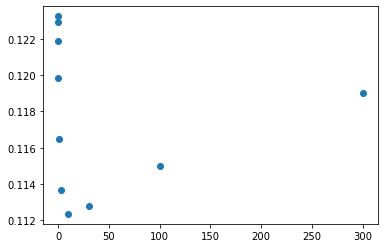

In [35]:
plt.scatter(test_rmse.index, test_rmse)

In [36]:
train_rmse = []
test_rmse = []
alphas = np.arange(5, 15)

for alp in alphas:
  ridge = Ridge(alpha=alp)
  scores = score_model(ridge, X_train, y_train)
  train_rmse.append(-np.mean(scores['train_score']))
  test_rmse.append(-np.mean(scores['test_score']))

test_rmse = pd.Series(test_rmse, index=alphas)
print('Min (test): alpha={}, rmse={}'.format(test_rmse.idxmin(), test_rmse.min()))

Min (test): alpha=12, rmse=0.11232637521855202


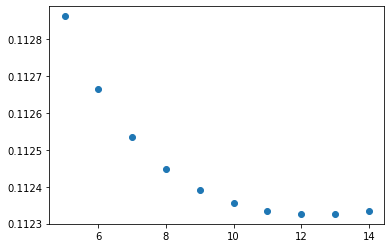

In [37]:
plt.scatter(test_rmse.index, test_rmse)

In [38]:
ridge = Ridge(alpha=12)
ridge.fit(X_train, y_train)


Ridge(alpha=12)

In [39]:
#5-Fold Cross Validation Score
rmse = rmsle_cv(ridge,X_train,y_train)

print(f'Average 5-Fold CV Score: {rmse}')

Average 5-Fold CV Score: 0.11232637521855202


In [40]:
generate_kaggle_submission(ridge, X_test, "ridge")

## Stack & Blend

We also try many other regression models with their several hyperparameters setup. 

In [41]:
X_train = train_clean
X_test = test_clean

In [42]:
grid(Lasso(random_state=1)).grid_get(X_train,y_train,5,{'alpha': [0.0001,0.0004,0.0005,0.0007],'max_iter':[10000, 15000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.10916912263050486
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0001, 'max_iter': 10000}         0.113883        0.001310
1  {'alpha': 0.0001, 'max_iter': 15000}         0.113883        0.001310
2  {'alpha': 0.0004, 'max_iter': 10000}         0.109268        0.001081
3  {'alpha': 0.0004, 'max_iter': 15000}         0.109268        0.001081
4  {'alpha': 0.0005, 'max_iter': 10000}         0.109169        0.001020
5  {'alpha': 0.0005, 'max_iter': 15000}         0.109169        0.001020
6  {'alpha': 0.0007, 'max_iter': 10000}         0.109480        0.000991
7  {'alpha': 0.0007, 'max_iter': 15000}         0.109480        0.000991


In [43]:
grid(ElasticNet(random_state=3)).grid_get(X_train,y_train,5,{'alpha': [0.0004,0.0005,0.0007,0.001], 'l1_ratio': [0.3, 0.6, 0.9]})

{'alpha': 0.0005, 'l1_ratio': 0.9} 0.10921683728962298
                                params  mean_test_score  std_test_score
0   {'alpha': 0.0004, 'l1_ratio': 0.3}         0.112417        0.001289
1   {'alpha': 0.0004, 'l1_ratio': 0.6}         0.110288        0.001217
2   {'alpha': 0.0004, 'l1_ratio': 0.9}         0.109389        0.001116
3   {'alpha': 0.0005, 'l1_ratio': 0.3}         0.111611        0.001269
4   {'alpha': 0.0005, 'l1_ratio': 0.6}         0.109734        0.001165
5   {'alpha': 0.0005, 'l1_ratio': 0.9}         0.109217        0.001039
6   {'alpha': 0.0007, 'l1_ratio': 0.3}         0.110637        0.001227
7   {'alpha': 0.0007, 'l1_ratio': 0.6}         0.109325        0.001055
8   {'alpha': 0.0007, 'l1_ratio': 0.9}         0.109334        0.000996
9    {'alpha': 0.001, 'l1_ratio': 0.3}         0.109819        0.001138
10   {'alpha': 0.001, 'l1_ratio': 0.6}         0.109438        0.000999
11   {'alpha': 0.001, 'l1_ratio': 0.9}         0.110339        0.000999


In [44]:
grid(Ridge(random_state=5)).grid_get(X_train,y_train,5,{'alpha': [5,10,15,20,30]})

{'alpha': 15} 0.11242936057492324
          params  mean_test_score  std_test_score
0   {'alpha': 5}         0.112979        0.001161
1  {'alpha': 10}         0.112449        0.001032
2  {'alpha': 15}         0.112429        0.000971
3  {'alpha': 20}         0.112536        0.000936
4  {'alpha': 30}         0.112854        0.000897


In [45]:
grid(KernelRidge(alpha=5,kernel='polynomial')).grid_get(X_train,y_train,5,{'degree':[2,3,4], 'coef0':[0.1,2.5,5]})

{'coef0': 5, 'degree': 3} 0.10963027548089592
                        params  mean_test_score  std_test_score
0  {'coef0': 0.1, 'degree': 2}         1.842989        0.068108
1  {'coef0': 0.1, 'degree': 3}         5.652702        0.178162
2  {'coef0': 0.1, 'degree': 4}         9.531173        0.398992
3  {'coef0': 2.5, 'degree': 2}         0.117604        0.000944
4  {'coef0': 2.5, 'degree': 3}         0.111628        0.000858
5  {'coef0': 2.5, 'degree': 4}         0.111432        0.000890
6    {'coef0': 5, 'degree': 2}         0.114307        0.000845
7    {'coef0': 5, 'degree': 3}         0.109630        0.000843
8    {'coef0': 5, 'degree': 4}         0.116836        0.001003


In [46]:
grid(SVR(C=20)).grid_get(X_train,y_train,5,{'gamma': [0.0001,0.0004,0.0008], 'epsilon': [0.001,0.005,0.01,0.05,0.1]})

{'epsilon': 0.01, 'gamma': 0.0004} 0.10940556522327068
                                 params  mean_test_score  std_test_score
0   {'epsilon': 0.001, 'gamma': 0.0001}         0.112702        0.001177
1   {'epsilon': 0.001, 'gamma': 0.0004}         0.109541        0.001188
2   {'epsilon': 0.001, 'gamma': 0.0008}         0.112297        0.001114
3   {'epsilon': 0.005, 'gamma': 0.0001}         0.112657        0.001194
4   {'epsilon': 0.005, 'gamma': 0.0004}         0.109477        0.001121
5   {'epsilon': 0.005, 'gamma': 0.0008}         0.111824        0.001119
6    {'epsilon': 0.01, 'gamma': 0.0001}         0.112617        0.001218
7    {'epsilon': 0.01, 'gamma': 0.0004}         0.109406        0.001107
8    {'epsilon': 0.01, 'gamma': 0.0008}         0.111422        0.001108
9    {'epsilon': 0.05, 'gamma': 0.0001}         0.111979        0.001122
10   {'epsilon': 0.05, 'gamma': 0.0004}         0.109576        0.001160
11   {'epsilon': 0.05, 'gamma': 0.0008}         0.113114        0.001

In [47]:
models = [  Lasso(alpha=0.0004, random_state=1, max_iter=10000),
            ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3), 
            Ridge(alpha=10,random_state=5),
            KernelRidge(alpha=5, kernel='polynomial', degree=3, coef0=5), 
            SVR(gamma= 0.0004,kernel='rbf',C=20,epsilon=0.05),
            BayesianRidge(),
            LinearSVR(),
            RandomForestRegressor(max_depth=10, max_features=50, n_estimators=200, min_samples_split=4, min_samples_leaf=5, ccp_alpha=92, random_state=123),
            LGBMRegressor(num_leaves=64, max_depth=6, learning_rate=0.1, n_estimators=150, min_child_weight=0.5, random_state=123),
         ]
names = ['Lasso', 'ElasticNet', 'Ridge', 'KernelRidge', 'SVR', 'BayesianRidge', 'LinearSVR', 'RandomForest', 'LGBM']

Average 5-Fold CV Score for each model

In [48]:
for name, model in zip(names, models):
    start = time.time()
    score = rmsle_cv(model,X_train,y_train,5)
    end = time.time()
    print("{}: {:.6f}, {:.4f} in {:.3f} s".format(name,score.mean(),score.std(),end-start))

Lasso: 0.109155, 0.0000 in 0.345 s
ElasticNet: 0.109113, 0.0000 in 0.281 s
Ridge: 0.112355, 0.0000 in 0.068 s
KernelRidge: 0.109562, 0.0000 in 0.510 s
SVR: 0.109448, 0.0000 in 0.772 s
BayesianRidge: 0.112439, 0.0000 in 0.839 s
LinearSVR: 0.133042, 0.0000 in 1.038 s
RandomForest: 0.398823, 0.0000 in 3.465 s
LGBM: 0.122726, 0.0000 in 0.812 s


In [49]:
m_lasso = Lasso(alpha =0.0004, random_state=1, max_iter=10000)
m_lasso.fit(X_train, y_train)
generate_kaggle_submission(m_lasso, X_test, "lasso")

m_elasticnet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
m_elasticnet.fit(X_train, y_train)
generate_kaggle_submission(m_elasticnet, X_test, "elasticnet")

m_ridge = Ridge(alpha=10,random_state=5)
m_ridge.fit(X_train, y_train)
generate_kaggle_submission(m_ridge, X_test, "ridge")

m_kernelridge = KernelRidge(alpha=5, kernel='polynomial', degree=3, coef0=5)
m_kernelridge.fit(X_train, y_train)
generate_kaggle_submission(m_kernelridge, X_test, "kernelridge")

m_svr = SVR(gamma= 0.0004,kernel='rbf',C=20,epsilon=0.05)
m_svr.fit(X_train, y_train)
generate_kaggle_submission(m_svr, X_test, "svr")

After trying several models, we try to leverage them by applying sophisticated techniques like stacking or blending.

In [50]:
sel_models =  [ Lasso(alpha=0.0004,random_state=1,max_iter=10000),
                ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3),
                Ridge(alpha=10,random_state=5),
                KernelRidge(alpha=5,kernel='polynomial',degree=3,coef0=5),
                SVR(gamma=0.0004,kernel='rbf',C=20,epsilon=0.05),
                BayesianRidge()
              ]

We will apply stack atop SVR since it has the best performance based on the test set score on Kaggle.

In [51]:
stack1 = StackingCVRegressor(
    regressors=sel_models,
    meta_regressor=SVR(gamma=0.0004,kernel='rbf',C=20,epsilon=0.05),
    use_features_in_secondary=True
)
stack1.fit(np.array(X_train), np.array(y_train))

StackingCVRegressor(meta_regressor=SVR(C=20, epsilon=0.05, gamma=0.0004),
                    regressors=[Lasso(alpha=0.0004, max_iter=10000,
                                      random_state=1),
                                ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                           random_state=3),
                                Ridge(alpha=10, random_state=5),
                                KernelRidge(alpha=5, coef0=5,
                                            kernel='polynomial'),
                                SVR(C=20, epsilon=0.05, gamma=0.0004),
                                BayesianRidge()],
                    use_features_in_secondary=True)

Stack1's Average 5-Fold CV Score

In [52]:
start = time.time()
score = rmsle_cv(stack1,np.array(X_train),np.array(y_train),5)
end = time.time()
print("{}: {:.6f}, {:.4f} in {:.3f} s".format("stack1",score.mean(),score.std(),end-start))

stack1: 0.109647, 0.0000 in 13.511 s


In [ ]:
generate_kaggle_submission(stack1, X_test, "stack1")

We also try to blend (manually assign weights) the results from different models.

In [53]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

We pick Ridge, KernelRidge, SVR and stack1 to blend together.

In [54]:
sel_models =  [ #Lasso(alpha=0.0004,random_state=1,max_iter=10000),
                #ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3),
                Ridge(alpha=10,random_state=5),
                KernelRidge(alpha=5,kernel='polynomial',degree=3,coef0=5),
                SVR(gamma=0.0004,kernel='rbf',C=20,epsilon=0.05),
                #BayesianRidge(),
                stack1
              ]

Blend's Average 5-Fold CV Score

In [55]:
#weights = [0.18,0.18,0.14,0.18,0.18,0.14]
#weights = [0.2,0.15,0.2,0.15,0.3]
weights = [0.1,0.1,0.4,0.4]

start = time.time()
blended = AverageWeight(mod=sel_models, weight=weights)
score = rmsle_cv(blended,np.array(X_train),np.array(y_train),5)
end = time.time()
print("blend: {:.6f}, {:.4f} in {:.3f} s".format(score.mean(),score.std(),end-start))

blend: 0.109236, 0.0000 in 14.862 s


In [56]:
blended.fit(np.array(X_train), np.array(y_train))

AverageWeight(mod=[Ridge(alpha=10, random_state=5),
                   KernelRidge(alpha=5, coef0=5, kernel='polynomial'),
                   SVR(C=20, epsilon=0.05, gamma=0.0004),
                   StackingCVRegressor(meta_regressor=SVR(C=20, epsilon=0.05,
                                                          gamma=0.0004),
                                       regressors=[Lasso(alpha=0.0004,
                                                         max_iter=10000,
                                                         random_state=1),
                                                   ElasticNet(alpha=0.0005,
                                                              l1_ratio=0.9,
                                                              random_state=3),
                                                   Ridge(alpha=10,
                                                         random_state=5),
                                                   KernelRidge(alpha=5, coef0=

In [ ]:
generate_kaggle_submission(blended, X_test, "blend")

## Decision Tree

In [57]:
X_train = train_clean
dt = DecisionTreeRegressor(random_state=564)
dt.fit(X_train,y_train)

DecisionTreeRegressor(random_state=564)

**5-fold Cross Validation Results**

In [58]:
#5-Fold Cross Validation Score
rmse = rmsle_cv(dt,X_train,y_train)

print(f'Average 5-Fold CV Score: {rmse}')

Average 5-Fold CV Score: 0.1867894869507288


In [ ]:
X_test = test_clean
generate_kaggle_submission(dt, X_test, "decision_tree")

## XGBoost

---



In [59]:
X_train = train_clean
train_X,val_X,train_y,val_y = train_test_split(X_train,y_train,random_state= 564)
X_test = test_clean

In [60]:
xgb_r = xgb.XGBRegressor(objective="reg:squarederror",max_depth=2,learning_rate=0.1,n_estimators=1000,reg_alpha=0.001,reg_lambda=0.001,n_jobs=-1,min_child_weight=3)
xgb_r.fit(train_X,train_y)

XGBRegressor(max_depth=2, min_child_weight=3, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror', reg_alpha=0.001, reg_lambda=0.001)

5-Fold Cross Validation Results

In [61]:
#5-Fold Cross Validation Score
rmse = rmsle_cv(xgb_r,X_train,y_train)
print(f'Average 5-Fold CV Score: {rmse}')

Average 5-Fold CV Score: 0.11565893826535438


In [ ]:
generate_kaggle_submission(xgb_r,X_test,'XGBoost')

# Neural Network

In [62]:
X_train = train_clean

In [63]:
regr = MLPRegressor(random_state=1, activation='tanh', hidden_layer_sizes=(100, 200, 100), max_iter=7500, n_iter_no_change=200).fit(X_train, y_train)

In [ ]:
#5-Fold Cross Validation Score
rmse = rmsle_cv(regr,X_train,y_train)

print(f'Average 5-Fold CV Score: {rmse}')

Average 5-Fold CV Score: 0.15007357521821083


In [ ]:
generate_kaggle_submission(regr, X_test, "mlp")

# Final Method: Stack

## Final Version of Preprocessing (Without outlier removal)

We found that not removing outliers gave us much better performance in this model

In [64]:
def final_fill_missing(dataset) :

  #Convert some numerical features to objects
  dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
  dataset['YrSold'] = dataset['YrSold'].astype(object)
  dataset['MoSold'] = dataset['MoSold'].astype(object)

  #Fill the values that shouldn't be interpreted as NA
  dataset['Alley'] = dataset['Alley'].fillna('None')
  dataset['MiscFeature'] = dataset['MiscFeature'].fillna('None')
  dataset['Fence'] = dataset['Fence'].fillna('None')
  dataset['MasVnrType'] = dataset['MasVnrType'].fillna('None')
  dataset['GarageType'] = dataset['GarageType'].fillna('None')
  dataset['LotFrontage'] = dataset['LotFrontage'].fillna(0)
  dataset['MasVnrArea'] = dataset['MasVnrArea'].fillna(0)
  dataset['Electrical'] = dataset['Electrical'].fillna('Unknown') 
  dataset['GarageYrBlt'] = dataset['GarageYrBlt'].fillna(int(train['GarageYrBlt'].mean()))

  # Testset missing data
  dataset['MSZoning'] = dataset['MSZoning'].fillna('None')
  dataset['Exterior1st'] = dataset['Exterior1st'].fillna('None')
  dataset['Exterior2nd'] = dataset['Exterior2nd'].fillna('None')
  dataset['SaleType'] = dataset['SaleType'].fillna('None')
  dataset['BsmtFullBath'] = dataset['BsmtFullBath'].fillna(0)
  dataset['BsmtHalfBath'] = dataset['BsmtHalfBath'].fillna(0)
  dataset['BsmtFinSF2'] = dataset['BsmtFinSF2'].fillna(0)
  dataset['TotalBsmtSF'] = dataset['TotalBsmtSF'].fillna(0)
  dataset['GarageArea'] = dataset['GarageArea'].fillna(0)
  dataset['GarageCars'] = dataset['GarageCars'].fillna(0)
  dataset['BsmtUnfSF'] = dataset['BsmtUnfSF'].fillna(0)
  dataset['BsmtFinSF1'] = dataset['BsmtFinSF1'].fillna(0)

  return dataset

In [65]:
def final_str_to_ord(dataset) :

  lot_shape_mapping = {"IR3": 4, "IR2": 3, "IR1": 2, "Reg":1}
  utilities_mapping = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub":4}
  land_slope_mapping = {"Sev": 3, "Mod": 2, "Gtl": 1}
  exter_mapping = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
  bsmt_mapping = {"NA": 1, "Po": 2, "Fa": 3, "TA": 4, "Gd": 5, "Ex": 6}
  bsmt_exposure_mapping = {"NA": 1, "No": 2, "Mn": 3, "Av":4, "Gd": 5}
  bsmt_fin_mapping = {"NA": 1, "Unf": 2, "LwQ": 3, "Rec":4, "BlQ": 5, "AlQ": 6, "GlQ": 7}
  functional_mapping = {"Sal": 1, "Sev": 2, "Maj2": 3, "Maj1":4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}
  garage_finish_mapping = {"NA": 1, "Unf": 2, "RFn": 3, "Fin":4}
  pool_mapping = {'NA': 1, 'FA': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
  paved_mapping = {'N':0, 'P': 1, 'Y': 2}
  dataset['LotShape'] = dataset['LotShape'].map(lot_shape_mapping).astype(int)
  #dataset['Utilities'] = dataset['Utilities'].map(utilities_mapping).astype(int)
  dataset['LandSlope'] = dataset['LandSlope'].map(land_slope_mapping).astype(int)
  dataset["ExterQual"] = dataset["ExterQual"].map(exter_mapping).astype(int)
  dataset["ExterCond"] = dataset["ExterCond"].map(exter_mapping).astype(int)
  dataset["BsmtQual"] = dataset["BsmtQual"].map(bsmt_mapping).fillna(1).astype(int)
  dataset["BsmtCond"] = dataset["BsmtCond"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['BsmtExposure'] = dataset['BsmtExposure'].map(bsmt_exposure_mapping).fillna(1).astype(int)
  dataset['BsmtFinType1'] = dataset['BsmtFinType1'].map(bsmt_fin_mapping).fillna(1).astype(int)
  dataset['BsmtFinType2'] = dataset['BsmtFinType2'].map(bsmt_fin_mapping).fillna(1).astype(int)
  dataset["HeatingQC"] = dataset["HeatingQC"].map(exter_mapping).fillna(1).astype(int)
  dataset["KitchenQual"] = dataset["KitchenQual"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['Functional'] = dataset['Functional'].map(functional_mapping).fillna(8).astype(int)
  dataset["FireplaceQu"] = dataset["FireplaceQu"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['GarageFinish'] = dataset['GarageFinish'].map(garage_finish_mapping).fillna(1).astype(int)
  dataset["GarageQual"] = dataset["GarageQual"].map(bsmt_mapping).fillna(1).astype(int)
  dataset["GarageCond"] = dataset["GarageCond"].map(bsmt_mapping).fillna(1).astype(int)
  dataset['PoolQC'] = dataset['PoolQC'].map(pool_mapping).fillna(1).astype(int)
  dataset['PavedDrive'] = dataset['PavedDrive'].map(paved_mapping).astype(int)
  return dataset

In [66]:
def final_feat_eng(dataset) :
  dataset['TotalSF'] = dataset[['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2', 'TotalBsmtSF', 'GarageArea']].sum(axis=1)
  dataset['TotalBath'] = dataset['BsmtFullBath']+dataset['FullBath']+0.5*(dataset['HalfBath']+dataset['BsmtHalfBath'])
  dataset['TotalPorchSF'] = dataset[['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']].sum(axis=1)

  #Combine related features
  dataset['ExterQualCond'] = dataset['ExterQual']+dataset['ExterCond']
  dataset['GrgQualCond'] = dataset['GarageQual']+dataset['GarageCond']
  dataset['BsmtQualCond'] = dataset['BsmtQual']+dataset['BsmtCond']+dataset['BsmtFinType1']+dataset['BsmtFinType2']
  dataset['OverallQualCond'] = dataset['OverallQual']+dataset['OverallCond']
  dataset['TotalQual'] = dataset['ExterQualCond']+dataset['GrgQualCond']+dataset['BsmtQualCond']+dataset['OverallQual']+dataset['HeatingQC']+dataset['KitchenQual']

  #add some indicator features
  dataset['HasGarage'] = dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasBsmt'] = dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasPool'] = dataset['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasFireplace'] = dataset['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
  dataset['HasPorch'] = dataset['TotalPorchSF'].apply(lambda x: 1 if x > 0 else 0)

  #drop irrelevant features
  dataset.drop(columns=['ExterQual','BsmtQual','GarageQual','HeatingQC','Utilities'],inplace=True)
  
  return dataset

In [67]:
def final_preprocess_data(dataset, train=True):
  targets = None
  if train:
    #Take log of targets, since in Kaggle scoring RMSE is calculated using log of targets
    targets = np.log(dataset['SalePrice'])
    dataset.drop(columns='SalePrice',inplace=True)

  ids = dataset['Id']
  dataset.drop(columns='Id', inplace=True)

  #Handle missing data
  proc_df = final_fill_missing(dataset)

  #map to ordinal
  proc_df = final_str_to_ord(proc_df)

  #feature engineering
  proc_df = final_feat_eng(proc_df)

  #scale numerical features
  num_feat = proc_df.select_dtypes([np.number])
  if train :
    ss = StandardScaler()
    ss.fit(num_feat)
    with open(gdrive_base+'std_scaler.pkl','wb') as f :
      pickle.dump(ss,f)
  else :
    with open(gdrive_base+'std_scaler.pkl','rb') as f :
      ss = pickle.load(f)
  num_feat = ss.transform(num_feat)

  num_feat = pd.DataFrame(num_feat, columns=proc_df.select_dtypes([np.number]).columns)

  #one hot encode
  cat_feat = proc_df.select_dtypes(['O'])
  if train :
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(cat_feat)
    with open(gdrive_base+'one_hot_enc.pkl','wb') as f :
      pickle.dump(ohe,f)
  else :
    with open(gdrive_base + 'one_hot_enc.pkl','rb') as f :
      ohe = pickle.load(f)
  train_oh = ohe.transform(cat_feat)
  feat_names = ohe.get_feature_names(cat_feat.columns)
  cat_feat = pd.DataFrame(train_oh,columns=feat_names)
  proc_df = pd.concat([num_feat,cat_feat],axis=1)

  if train: 
    print(f"Processed Train Set Shape: {proc_df.shape}")
  else :
    print(f"Processed Test Set Shape: {proc_df.shape}")
  return ids,proc_df,targets

## Final Training

In [68]:
#Load Raw Data
train = pd.read_csv(gdrive_base + 'train.csv')
test = pd.read_csv(gdrive_base + 'test.csv')

#Preprocess Data
_,train_clean,y_train = final_preprocess_data(train,train=True)
test_ids,test_clean,_ = final_preprocess_data(test,train=False)
#y_train = np.log(train['SalePrice'])
X_train = train_clean
X_test = test_clean

Processed Train Set Shape: (1460, 267)
Processed Test Set Shape: (1459, 267)


In [69]:
rf_params = {"max_depth": 10, "max_features": 50, "n_estimators": 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'ccp_alpha': 92}
svr_params = {
    "kernel": "poly",
    "C": 0.1,
    "epsilon": 0.05,
    "coef0": 0.75,
}
ridge_params = {
    "alpha": 0.999,
    "tol": 0.87,
    "solver": "cholesky",
}
lasso_params = {"alpha": 0.0002, "selection": "random"}
lgbm_params = {
    "num_leaves": 64,
    "max_depth": 6,
    "learning_rate": 0.1,
    "n_estimators": 150,
    "min_child_weight": 0.5,
}
random_state = 123

In [70]:
rf = RandomForestRegressor(**rf_params, random_state=random_state)
svr = SVR(**svr_params)
ridge = Ridge(**ridge_params, random_state=random_state)
lasso = Lasso(**lasso_params, random_state=random_state)
lgbm = LGBMRegressor(**lgbm_params, random_state=random_state)
stack = StackingCVRegressor(
    regressors=[svr, ridge, lasso, lgbm, rf],
    meta_regressor=LinearRegression(n_jobs=-1),
    random_state=random_state,
    cv=KFold(n_splits=5),
    n_jobs=-1,
)
stack.fit(X_train, y_train)

StackingCVRegressor(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                    meta_regressor=LinearRegression(n_jobs=-1), n_jobs=-1,
                    random_state=123,
                    regressors=[SVR(C=0.1, coef0=0.75, epsilon=0.05,
                                    kernel='poly'),
                                Ridge(alpha=0.999, random_state=123,
                                      solver='cholesky', tol=0.87),
                                Lasso(alpha=0.0002, random_state=123,
                                      selection='random'),
                                LGBMRegressor(max_depth=6, min_child_weight=0.5,
                                              n_estimators=150, num_leaves=64,
                                              random_state=123),
                                RandomForestRegressor(ccp_alpha=92,
                                                      max_depth=10,
                                                      max_featu

5-Fold Cross Validation Score

In [71]:
start = time.time()
score = rmsle_cv(stack,X_train,y_train,5)
end = time.time()
print("{}: {:.6f}, {:.4f} in {:.3f} s".format("stack",score.mean(),score.std(),end-start))

stack: 0.118131, 0.0000 in 17.083 s


In [72]:
generate_kaggle_submission(stack, X_test, "stack2")
#Final Kaggle Score: 0.11725

# **Permutation Importance**

---
Analyzing the most important features for our model



In [73]:
train_X,val_X,train_y,val_y = train_test_split(X_train,y_train,random_state= 564)

In [75]:
importance = permutation_importance(stack,val_X,val_y,n_repeats=10,random_state=0,scoring='neg_root_mean_squared_error')

In [76]:
#Most important features, by permutation importance
for i in importance.importances_mean.argsort()[::-1] :
  if importance.importances_mean[i] - 2*importance.importances_std[i] > 0:
    print(f"{val_X.columns[i]:<8}  "
    f"{importance.importances_mean[i]:.3f}"
    f" +/- {importance.importances_std[i]:.3f}")

TotalSF   0.063 +/- 0.004
GrLivArea  0.044 +/- 0.003
OverallQual  0.028 +/- 0.002
TotalQual  0.021 +/- 0.001
OverallQualCond  0.017 +/- 0.001
YearBuilt  0.014 +/- 0.002
1stFlrSF  0.009 +/- 0.001
OpenPorchSF  0.009 +/- 0.001
LotArea   0.009 +/- 0.001
GarageCars  0.006 +/- 0.001
2ndFlrSF  0.006 +/- 0.001
TotalBsmtSF  0.006 +/- 0.001
YearRemodAdd  0.006 +/- 0.001
TotalBath  0.005 +/- 0.001
Functional  0.005 +/- 0.001
OverallCond  0.004 +/- 0.001
TotalPorchSF  0.004 +/- 0.001
PoolArea  0.004 +/- 0.000
BsmtFinSF1  0.003 +/- 0.001
BsmtFinType1  0.003 +/- 0.001
Condition2_PosN  0.003 +/- 0.000
Condition1_Norm  0.003 +/- 0.001
Neighborhood_Crawfor  0.003 +/- 0.000
FireplaceQu  0.003 +/- 0.001
KitchenQual  0.003 +/- 0.000
GarageArea  0.003 +/- 0.001
TotRmsAbvGrd  0.003 +/- 0.001
HasPool   0.002 +/- 0.000
ExterCond  0.002 +/- 0.000
MasVnrArea  0.002 +/- 0.001
Fireplaces  0.002 +/- 0.001
GarageYrBlt  0.002 +/- 0.000
BsmtExposure  0.002 +/- 0.001
BsmtUnfSF  0.002 +/- 0.000
KitchenAbvGr  0.002 +/- 

In [77]:
top12 =  importance.importances_mean.argsort()[::-1][:12] 
top12mean = [ importance.importances_mean[i] for i in top12 ]
top12std = [ importance.importances_std[i] for i in top12 ]
top12feat = [ val_X.columns[i] for i in top12 ]

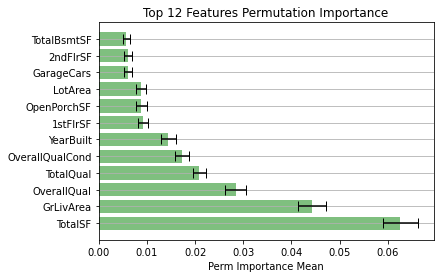

In [78]:
# Plot permutation Improtance for top 12 features
y_pos = list(range(12))
fig, ax = plt.subplots()
ax.barh(y_pos, top12mean, xerr=top12std, align='center', alpha=0.5, ecolor='black', capsize=5,color='green')
ax.set_xlabel('Perm Importance Mean')
ax.set_yticks(y_pos)
ax.set_yticklabels(top12feat)
ax.set_title('Top 12 Features Permutation Importance')
ax.yaxis.grid(True)

#plt.savefig('bar_plot_with_error_bars.png')
plt.show()